##### calculate velocity using the RNA Velocity Basics tutorial
https://scvelo.readthedocs.io/en/stable/VelocityBasics/
Version 0.2.4 (as of 20/08/2023))

original publication:
Bergen, V., Lange, M., Peidli, S. et al. Generalizing RNA velocity to transient cell states through dynamical modeling. Nat Biotechnol 38, 1408–1414 (2020). https://doi.org/10.1038/s41587-020-0591-3

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy as sci
from scipy.sparse import csr_matrix
from scipy import sparse
import scvelo as scv
import loompy
import seaborn as sns
!pip install python-igraph --upgrade --quiet

In [4]:
sc.settings.verbosity = 3    
sc.logging.print_versions()
results_file = './write/scVelo_flow.h5ad' 
scv.settings.set_figure_params(dpi=80,dpi_save=600,vector_friendly=True,figsize=(6,6),fontsize=10)

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.1
cloudpickle                 2.2.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
dask                        2022.9.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.18
fsspec                      2022.8.2
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.10.4
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  8.0.6
jedi                        0.18.1
jinja2                      3.1.2
joblib     

## Data loading: load analysis of flow vs static (merged, filtered and cluster-annotated),but analyze only flow cells for velocity

In [5]:
adata=sc.read_h5ad(r"F:\Velocity\velocity_version_flow.h5ad", backed=None, chunk_size=6000)

In [6]:
adata

AnnData object with n_obs × n_vars = 2511 × 2212
    obs: 'id', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden', 'cell type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell type_colors', 'dendrogram_leiden', 'hvg', 'id_colors', 'leiden', 'leiden_1.0_colors', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
#load loom file 
ldata = scv.read(r'F:Velocity\42_09_19_flow.loom')

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [9]:
ldata


AnnData object with n_obs × n_vars = 6593 × 33538
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [10]:
adata

AnnData object with n_obs × n_vars = 2511 × 2212
    obs: 'id', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden', 'cell type'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell type_colors', 'dendrogram_leiden', 'hvg', 'id_colors', 'leiden', 'leiden_1.0_colors', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
%load_ext autoreload
%autoreload 2

In [13]:
scvadata = scv.utils.merge(ldata,adata,id_length=16)
scvadata

AnnData object with n_obs × n_vars = 2511 × 2098
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'id', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden_1.0', 'leiden', 'cell type'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell type_colors', 'dendrogram_leiden', 'hvg', 'id_colors', 'leiden', 'leiden_1.0_colors', 'leiden_colors', 'neighbors', 'pca', 'phase_colors', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [15]:
ldata.obs_names

Index(['AAAGAACCAATAACCC', 'AAAGTCCTCTCTATAC', 'AAACGCTCATTAAGCC',
       'AACAAAGTCCACACAA', 'AAACGCTGTCCTCATC', 'AAAGTGAAGTAAACAC',
       'AACAAAGGTACCGCGT', 'AACAACCCATTCCTAT', 'AACAAGAAGGGACTGT',
       'AAACGAATCATCCTGC',
       ...
       'TTTGATCCAAGAAACT', 'TTTCACACAGAATCGG', 'TTTGATCGTGTCATCA',
       'TTTCCTCGTGAGATAT', 'TTTGATCAGTAAGACT', 'TTTGATCAGCCTCGTG',
       'TTTGACTTCATTATCC', 'TTTATGCGTAGACTGG', 'TTTATGCTCGCATGAT',
       'TTTGATCAGTCGCGAA'],
      dtype='object', length=6593)

In [16]:
len("AAAGAACCAATAACCC")

16

In [17]:
scvadata.var_names_make_unique()
scvadata.obs_names_make_unique()

# Filter steps 

In [18]:
#filter, normalize, logarithmize
scv.pp.filter_genes(scvadata, min_shared_counts=20)
scv.pp.normalize_per_cell(scvadata)
scv.pp.filter_genes_dispersion(scvadata, n_top_genes=2000)
scv.pp.log1p(scvadata)

Filtered out 692 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [19]:
#compute momemnts
scv.pp.filter_and_normalize(scvadata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(scvadata, n_pcs=30, n_neighbors=30)

Filtered out 64 genes that are detected 20 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:08) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# getting an overview

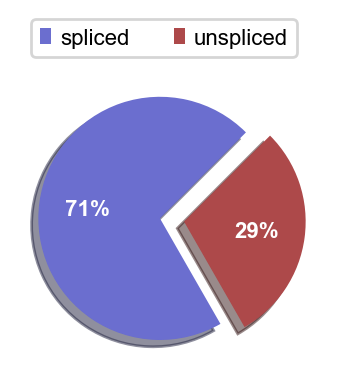

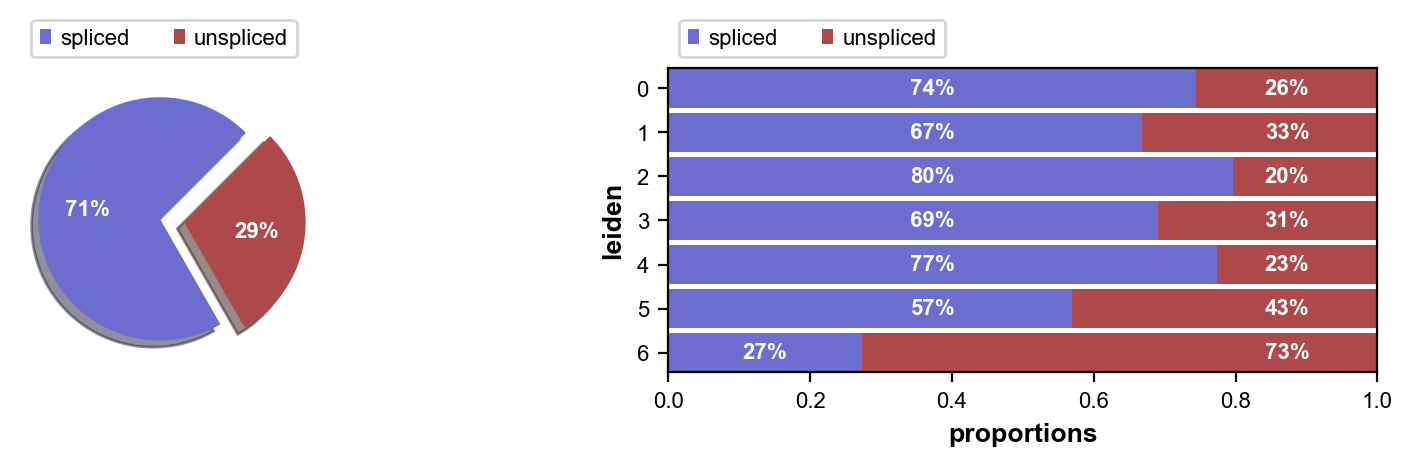

In [20]:
scv.pl.proportions(scvadata)
scv.pl.proportions(scvadata, groupby='leiden', layers=None, highlight='unspliced', add_labels_pie=True, add_labels_bar=True, fontsize=8, figsize=(10, 2), dpi=100)

In [21]:
#Velocity analysis 

In [22]:
scv.tl.velocity(scvadata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [23]:
scv.tl.velocity_graph(scvadata)

computing velocity graph (using 1/6 cores)


  0%|          | 0/2511 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


saving figure to file ./figures/scvelo_velocity_basic_flow.svg


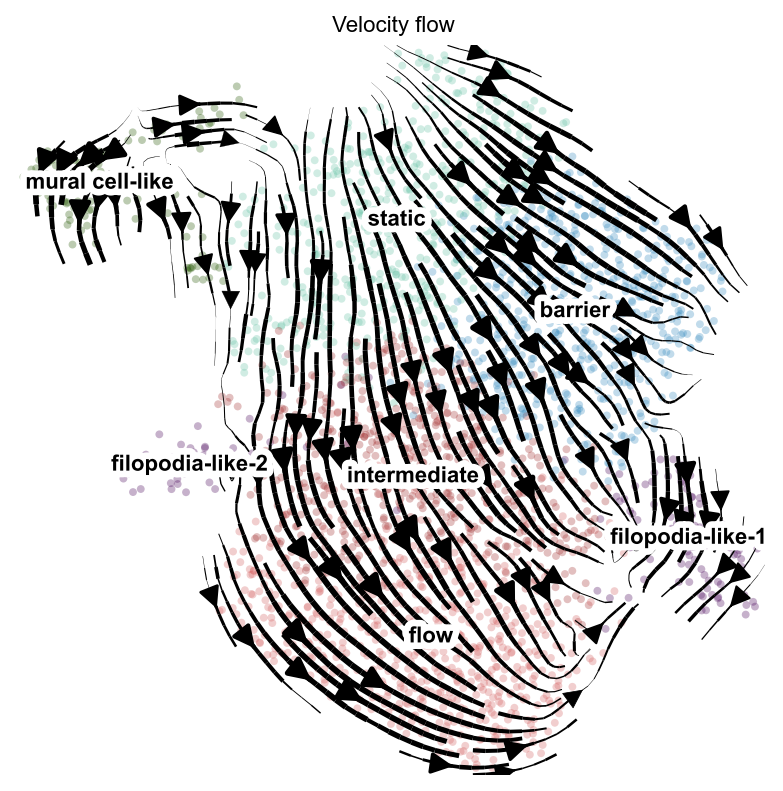

In [30]:
scv.pl.velocity_embedding_stream(scvadata, basis='umap',size= 50,  color = 'cell type', title =" Velocity flow", legend_loc='on data',
           legend_fontoutline=6,legend_fontsize=10,save=('velocity_basic_flow.svg'),arrow_size =2, linewidth=1.5)


# identify cluster-specific differential velocity expression  e.g. identify genes that may help explain the resulting vector field and inferred lineages.

In [31]:
#. The module scv.tl.rank_velocity_genes runs a differential velocity t-test and outpus a gene ranking for each cluster. 
#Thresholds can be set (e.g. min_corr) to restrict the test on a selection of gene candidates.
scv.tl.rank_velocity_genes(scvadata, groupby='leiden', min_corr=.3)
df = scv.DataFrame(scvadata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


C:\Users\maren.marder\Miniconda3\envs\xdbit\lib\site-packages\scvelo\tools\utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:00) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


C:\Users\maren.marder\AppData\Local\Temp\ipykernel_10592\2656501965.py:5: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(scvadata.uns['rank_velocity_genes']['names'])


0        1        2       3        4         5      6
0   SPRY4    BTNL9    PDE4B   KITLG     FAT1    PGM2L1   RALA
1  EEF1B2    MYOM2  COL11A1    AMD1      FN1    SH3BP5   PKIB
2    SAT1    ITPR2    THSD4  IGFBP7   COL8A1  ARHGAP28  BAALC
3  SNRPD3  RPS6KA5    FLRT2   SMAD1  ANGPTL4    TGFBR3   CDH2
4   ITGA2    MERTK     NQO1   CREB5    PAPPA    GIMAP8  GAP43


# Velocities in cycling progenitors

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    230 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    290 total control genes are used. (0:00:00)
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


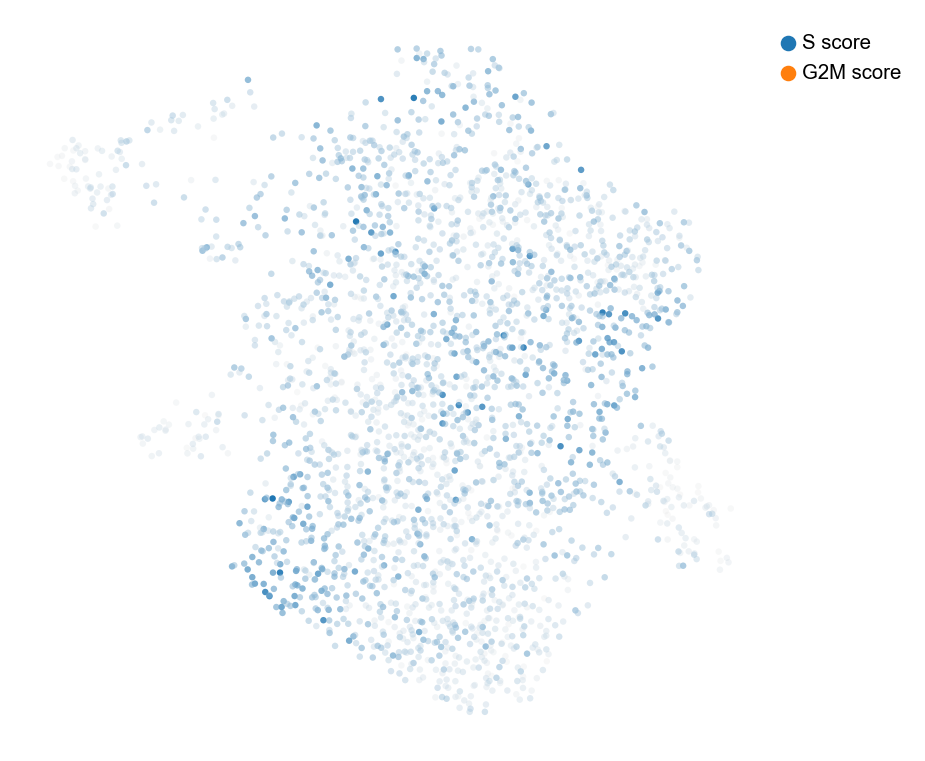

In [33]:

scv.tl.score_genes_cell_cycle(scvadata)
scv.pl.scatter(scvadata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

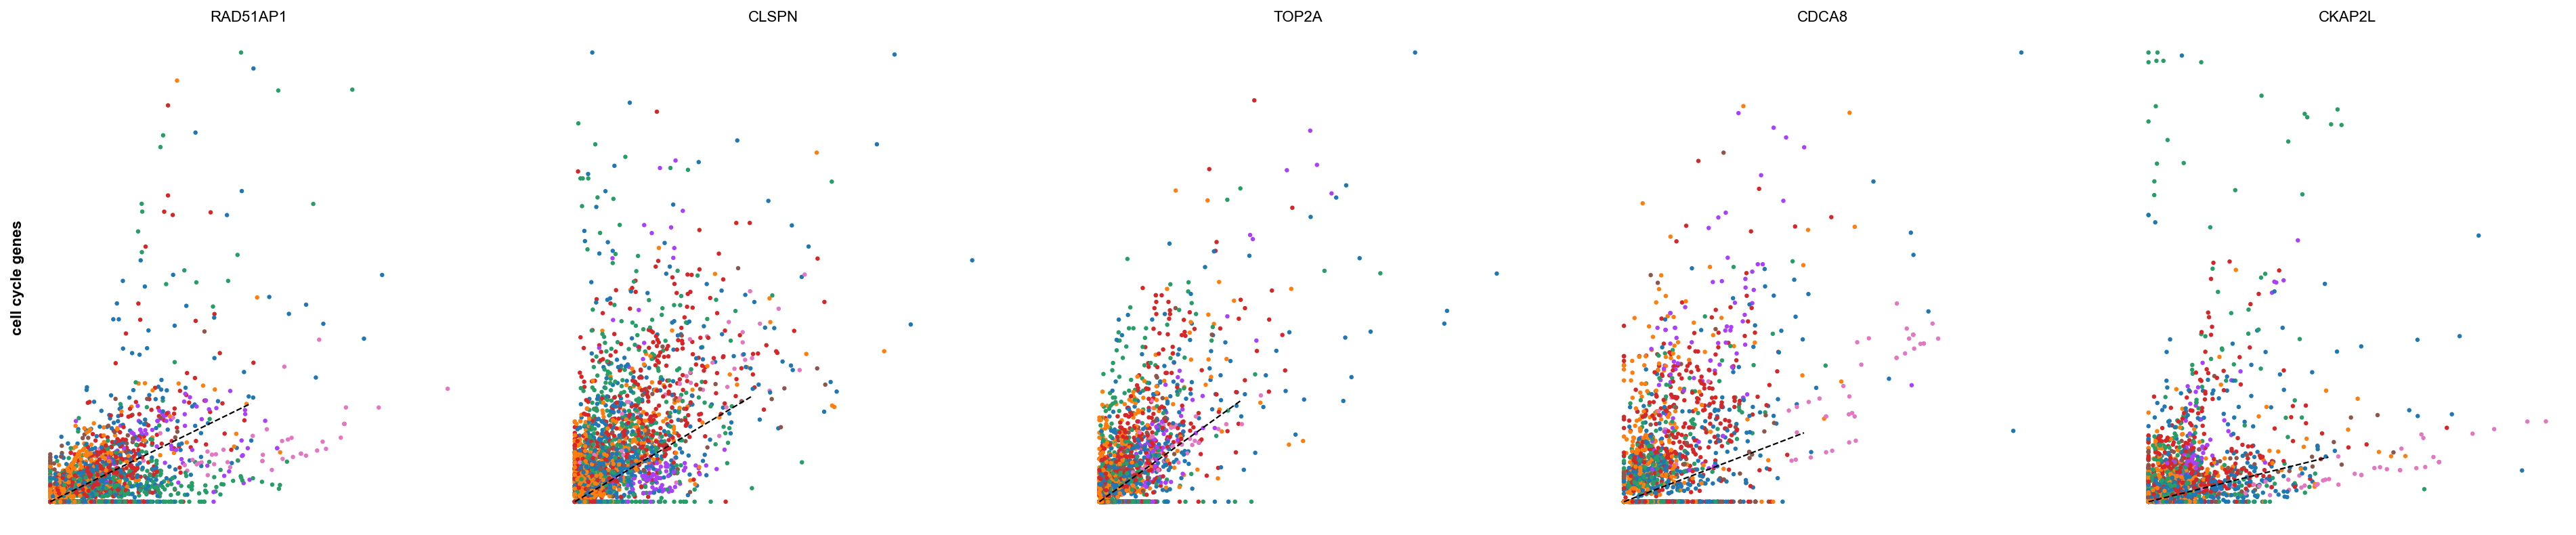

In [34]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(scvadata)
s_genes = scv.get_df(scvadata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(scvadata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(scvadata, list(s_genes[:2]) + list(g2m_genes[:3]), color= 'leiden',**kwargs)

# Speed and coherence

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


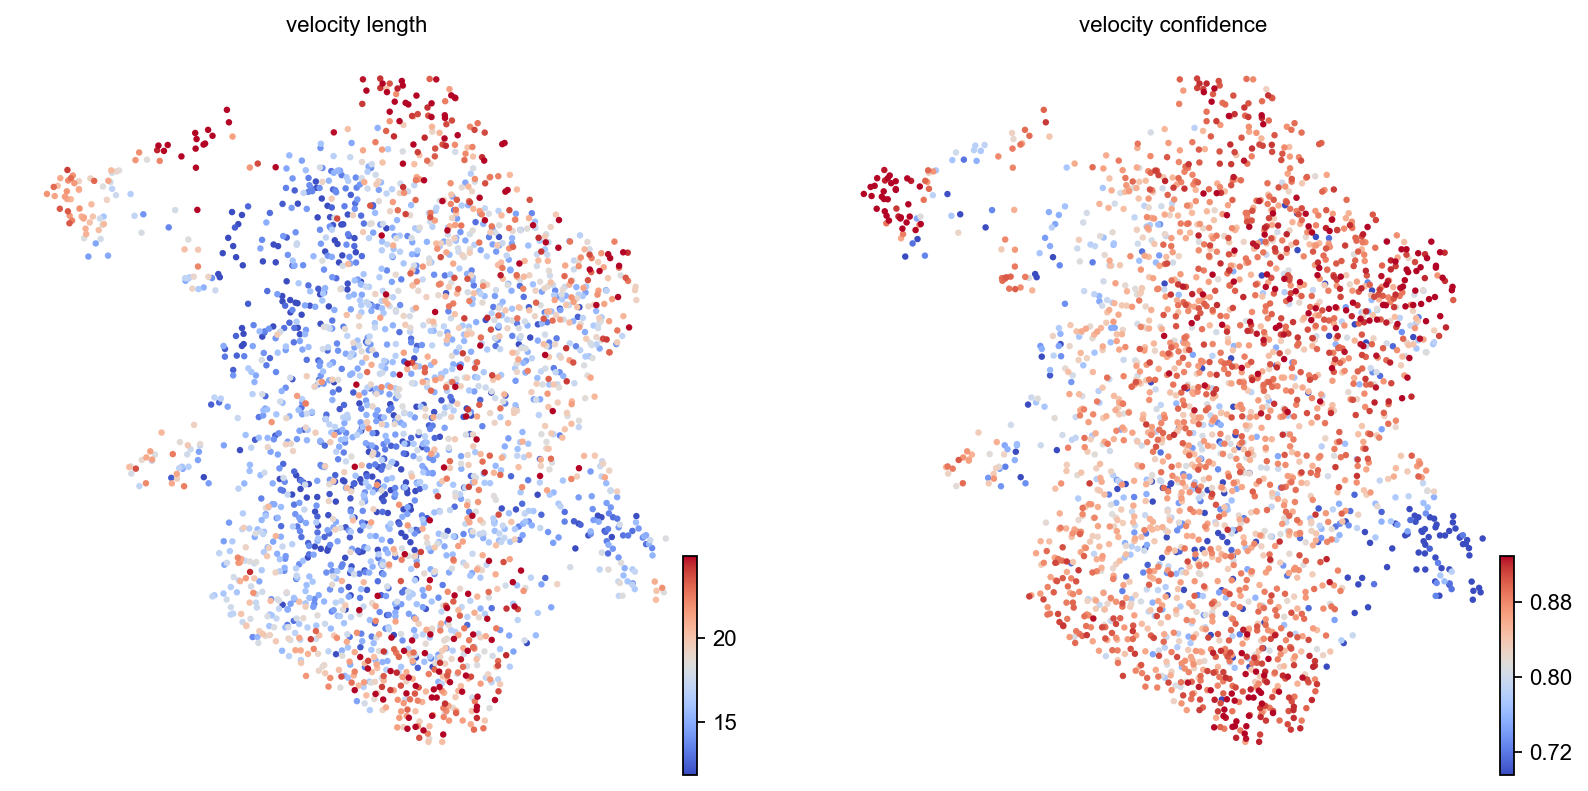

In [35]:

scv.tl.velocity_confidence(scvadata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(scvadata, c=keys, cmap='coolwarm', perc=[5, 95])

In [37]:
# on cluster level
df = scvadata.obs.groupby('cell type')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

# Velocity graph and pseudotime

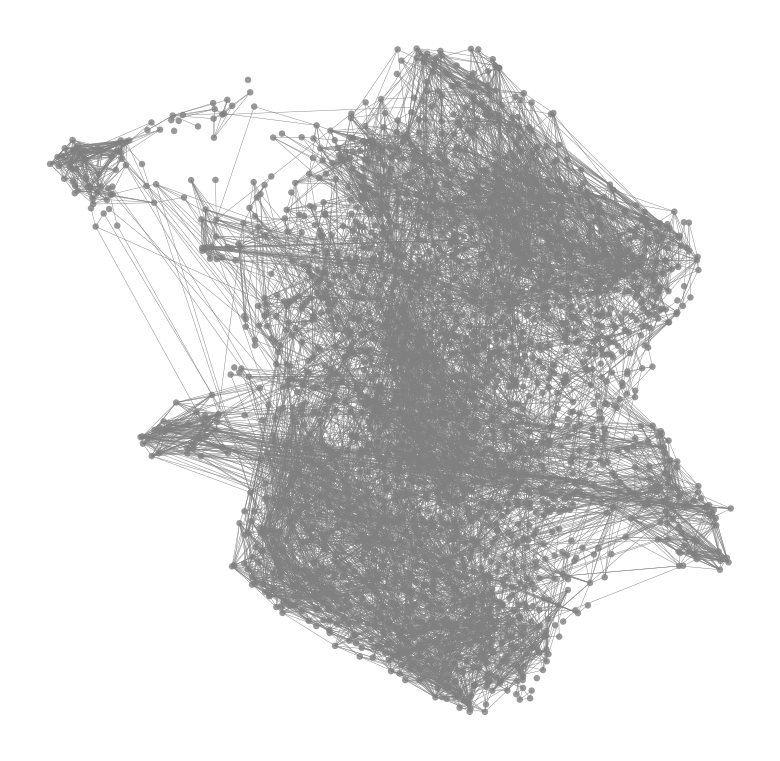

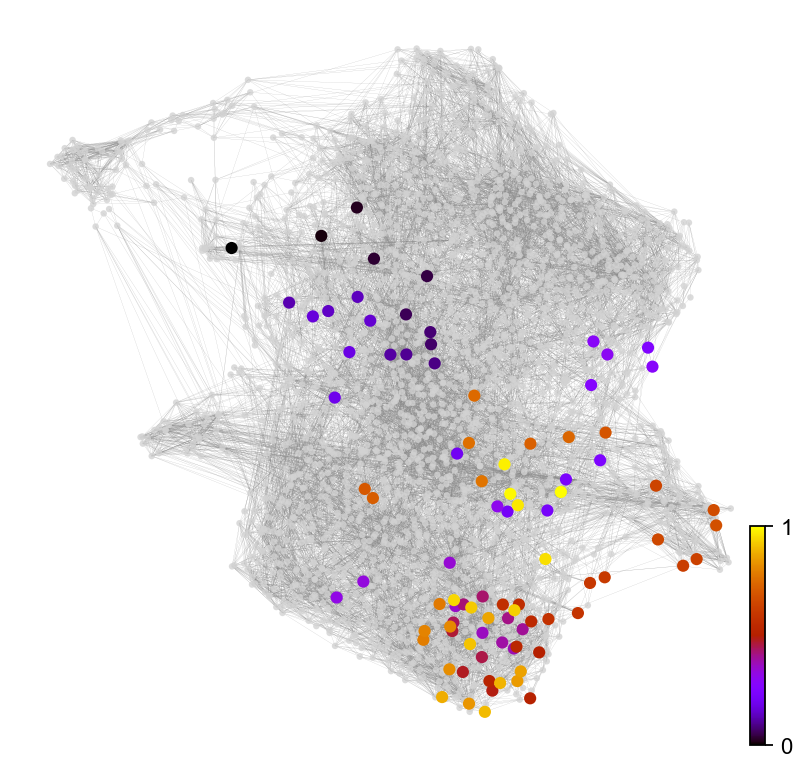

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


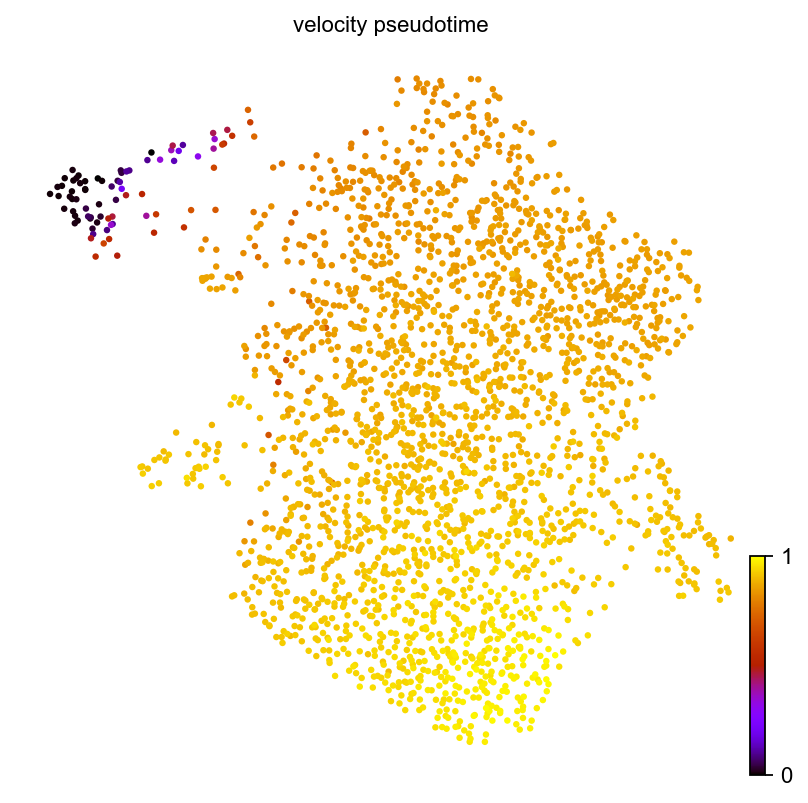

In [38]:
#velocity graph
scv.pl.velocity_graph(scvadata, threshold=.1)

x, y = scv.utils.get_cell_transitions(scvadata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(scvadata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(scvadata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

#velocity pseudotime graph

scv.tl.velocity_pseudotime(scvadata)
scv.pl.scatter(scvadata, color='velocity_pseudotime', cmap='gnuplot')

# PAGA velocity graph

In [39]:
# PAGA requires to install igraph, if not done yet.
!pip install python-igraph --upgrade --quiet

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


C:\Users\maren.marder\Miniconda3\envs\xdbit\lib\site-packages\networkx\convert.py:158: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `from_scipy_sparse_array` instead.
  return nx.from_scipy_sparse_matrix(data, create_using=create_using)


saving figure to file ./figures/scvelo_paga_celltype_flow-05122022.svg


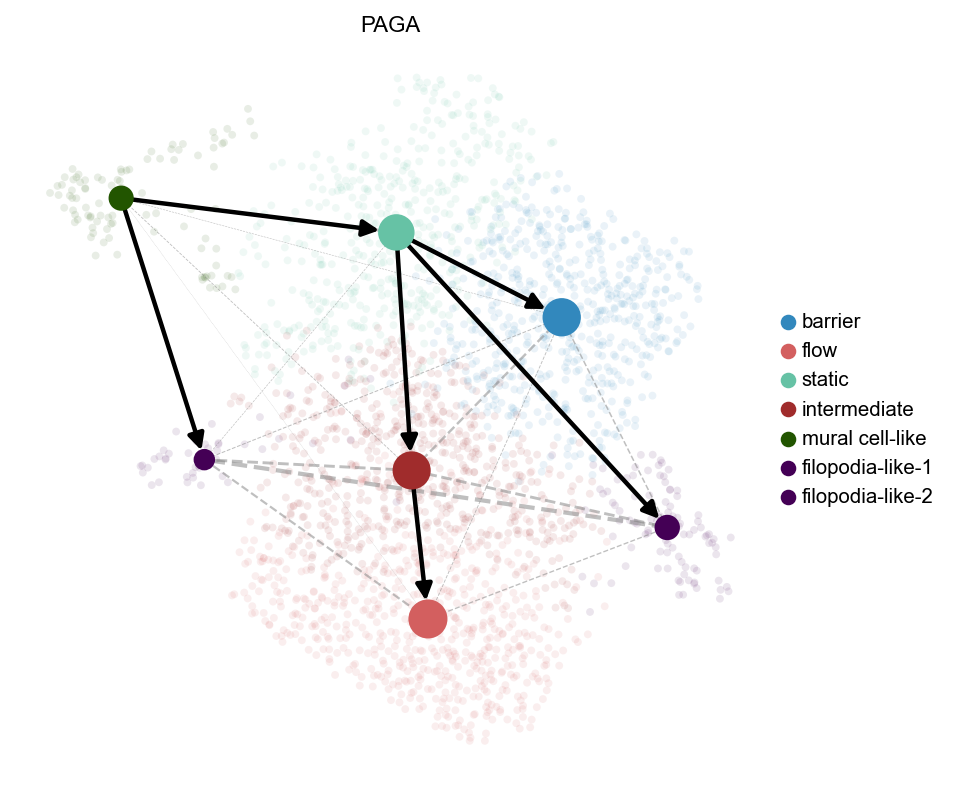

<Figure size 480x480 with 0 Axes>

In [41]:
scv.tl.paga(scvadata, groups='cell type')
df = scv.get_df(scvadata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')


scv.pl.paga(scvadata, basis='umap',size=50, alpha=.1, title = "PAGA",
            min_edge_width=2, node_size_scale=1.5, save="paga_celltype_flow.svg")
